In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, butter, filtfilt
from scipy.optimize import curve_fit
from matplotlib.mlab import psd

In [2]:
## define constants (SI units)
kb = 1.38e-23 # SI units
radius = 5 ## um
rho = 1.8 # g/cm^3
um_to_m = 1e-6
g_cm3_to_kg_m3 = 1e3 # g/cm^3 to kg/m^3
m_to_nm = 1e9 # meters to nm
mev_to_kgms = 5.34e-22 # MeV/c to kg m/s
sphere_mass = 4/3 * np.pi * (radius*um_to_m)**3 * rho * g_cm3_to_kg_m3
Fs=1e4 #Hz

print("Sphere mass is [g]: ", sphere_mass*1e3)

Sphere mass is [g]:  9.424777960769375e-10


In [3]:
def gen_waveform(f0, gam, teff, p0=0, disp_noise=0, T=1, Fs=Fs):
    """ generate simulated sphere data
        
        f0: res freq [Hz]
        gam: damping rate [Hz]
        teff: effective temperature of spehre [K]
        p0: Momentum of signal, kg*m/s (if > 0 add impulse to wf)
        disp_noise: displacement noise [m/rtHz, set to 0 by default]
        T: time of trace, s [0.1 s default]
        Fs: sampling rate, Hz [10 kHz default]
        
        returns time stream of sphere position
    """
    
    
    time = np.arange(0,T,1/Fs)
    num_pts = len(time)

    #Generate the noise
    noise = np.random.randn(num_pts)
    psi = np.fft.rfft(noise)
    freq = np.fft.rfftfreq(num_pts, d=1/Fs)
    omega = 2*np.pi*freq

    omega0 = 2*np.pi*f0

    norm = np.sqrt(2*kb*teff*gam/sphere_mass) * np.sqrt(Fs)

    xk = norm * psi/( omega0**2 - omega**2 + 1j*gam*omega ) 

    x = np.fft.irfft(xk) 
    x += disp_noise*np.random.randn(num_pts)*np.sqrt(Fs/2) #add displacement noise is desired

    ## might eventually add 1/f noise here if needed
    
    # if desired, add an impulse
    sig_temp = np.zeros_like(time)
    if(p0 > 0):
        omega1 = np.sqrt( omega0**2 - (gam/2)**2 )
        t0 = T/2
        sig = p0/(sphere_mass*omega1) * np.exp(-0.5*gam*(time - t0)) * np.sin(omega1*(time-t0))
        sig[time<t0]=0
        x += sig
        sig_temp = sig/np.max(sig)
        
    return x, time, sig_temp

In [4]:
def calc_force_psd(x, f0, gam, teff, Fs=Fs, make_plot=False):
    
    navg = 2**2 # number of averages for PSD calc, assume power of 2
    
    omega0 = 2*np.pi*f0
    
    x_psd, f_x = psd(x, NFFT=int(len(x)), Fs=Fs) #displacement PSD
    
    xk = np.fft.rfft(x)
    fk = np.fft.rfftfreq(len(x), 1/Fs)
    omega = 2*np.pi*fk
    
    forcek = xk * sphere_mass * (omega0**2 - omega**2 + 1j*gam*omega)
    
    force = np.fft.irfft(forcek)
    
    force_psd, f_force = psd(force, NFFT=int(len(x)), Fs=Fs) #force PSD
    
    if(make_plot):
        plt.figure()
        plt.semilogy(f_x, np.sqrt(x_psd))
        plt.xlabel("Freq [Hz]")
        plt.ylabel("Displacement ASD, [nm/$\sqrt{\mathrm{Hz}}$]")
        print("sqrt of integral of displacement psd: ", np.sqrt(np.trapz(x_psd, f_x)) )
        print("rms from equipartion: ", np.sqrt(kb*teff/(sphere_mass * omega0**2))  )
        plt.xlim(40,90)
        plt.ylim(5e-12,1e-7)
        
        plt.figure()
        plt.semilogy(f_force, np.sqrt(force_psd))
        plt.xlabel("Freq [Hz]")
        plt.ylabel("Force ASD, [N/$\sqrt{\mathrm{Hz}}$]")
        plt.xlim(0,100)
        
    return f_force, force_psd, f_x, x_psd

In [5]:
## this needs to be done on the force time stream insstead of the displacement
## time stream since otherwise will not opimially weight signal frequencies (?)
def optimal_filter(x, J, template, f0, gam, teff, nwindow=20, Fs=1e4):
    """ Apply the optimal filter to force time stream for known noise
        spectrum and signal template. 
        
        x - displacement time stream
        J - Noise psd
        template - normalized signal template (for force)
    """
    num_pts = len(x)
    
    omega0 = 2*np.pi*f0
    freqs = np.fft.rfftfreq(num_pts, 1/Fs)
    omega = 2*np.pi*freqs
    
    xk = np.fft.rfft(x)
    fk = xk * sphere_mass * ( omega0**2 - omega**2 + 1j*gam*omega ) ## force
    
    #plt.figure()
    #plt.loglog(freqs,np.abs(fk))
    
    sk = np.fft.rfft(template)
    
    norm = np.sum( np.abs(sk)**2/J )
    
    ## use the ifft to compute the filter as a function of 
    ## time offset for the template
    optf = np.fft.irfft( np.conj(fk)*sk/J ) * 1/norm * np.sqrt(Fs)/(2*np.pi) ## last factor here is strange, but 
                                                                             ## approx gives right amplitude
    
    return optf

In [6]:
def gauss(x, A, mu, sig):
    return A * np.exp(-(x-mu)**2/(2*sig**2))

0
0
0
0
0
0


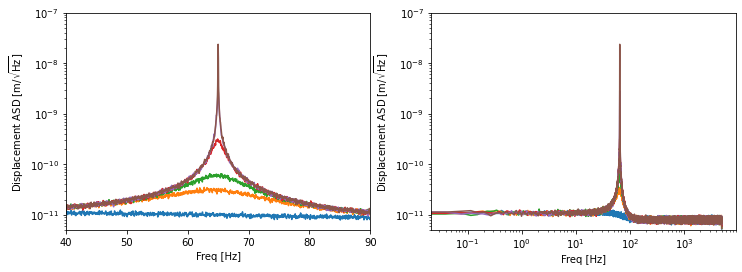

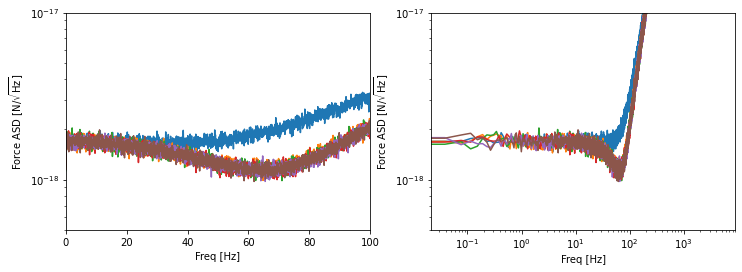

In [11]:
## set up parameters similar to Fernando's measurement from https://arxiv.org/pdf/2001.10931.pdf
gam_temp_ratio = 50e-6 * 500 # empirical ratio needed to match Fernando's plot
gam_list = [500, 100, 50, 10, 1, 0.1]

T = 2**18/1e4 #time of waveform, s

force_fig = plt.figure(figsize = (12,4))
disp_fig = plt.figure(figsize = (12,4))

J_dict = {}

for gam in gam_list:
    res_params = {'f0': 65, 'gam': gam, 'teff': gam_temp_ratio/gam}

    disp_noise_fernando = 8e-12 #m/rtHz, based on out-of-loop sensor

    #x, t, sig = gen_waveform(p0=0, T=2**18/1e4, disp_noise = disp_noise_fernando, **res_params)
    #f, p = calc_force_psd(x, **res_params, make_plot=True)

    ## make noise PSD (averaging over 500 wfs)
    n_avg = int(1e2)
    for i in range(n_avg):
        if(i % 100 == 0): print(i)
        x, t, sig = gen_waveform(p0=0, T=T, disp_noise = disp_noise_fernando, **res_params)
        ff, pf, fx, px = calc_force_psd(x, **res_params)
        if(i==0):
            ptot_f = pf
            ptot_x = px
        else:
            ptot_f += pf
            ptot_x += px

    ptot_f /= n_avg
    ptot_x /= n_avg

    J_dict[gam] = ptot_f ## save noise PSD for opt filter
    
    ## plot of force PSD
    plt.figure(disp_fig.number)
    plt.subplot(1,2,1)
    plt.semilogy(fx, np.sqrt(ptot_x))
    plt.xlim(40,90)
    plt.ylim(5e-12, 1e-7)
    plt.xlabel("Freq [Hz]")
    plt.ylabel("Displacement ASD [m/$\sqrt{\mathrm{Hz}}$]")

    plt.subplot(1,2,2)
    plt.loglog(fx, np.sqrt(ptot_x))
    plt.ylim(5e-12, 1e-7)
    plt.xlabel("Freq [Hz]")
    plt.ylabel("Displacement ASD [m/$\sqrt{\mathrm{Hz}}$]")
    
    ## plot of force PSD (Fernando zoom)
    plt.figure(force_fig.number)
    plt.subplot(1,2,1)
    plt.semilogy(ff, np.sqrt(ptot_f))
    plt.xlim(0,100)
    plt.ylim(5e-19, 1e-17)
    plt.xlabel("Freq [Hz]")
    plt.ylabel("Force ASD [N/$\sqrt{\mathrm{Hz}}$]")

    ## full zoom
    plt.subplot(1,2,2)
    plt.loglog(ff, np.sqrt(ptot_f))
    plt.ylim(5e-19, 1e-17)
    plt.xlabel("Freq [Hz]")
    plt.ylabel("Force ASD [N/$\sqrt{\mathrm{Hz}}$]")
    
plt.show()

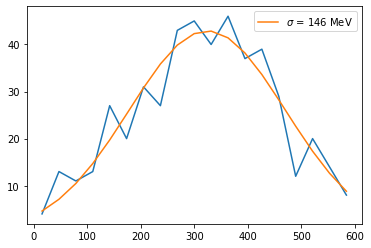

In [12]:
## apply optimal filter for impulsive force
## parameters above matching Fernando
Fs = 1e4

gam = 100 ## just before squashing
res_params = {'f0': 65, 'gam': gam, 'teff': gam_temp_ratio/gam}

x, t, sig = gen_waveform(p0=1.4e-19, T=2**18/1e4, disp_noise = disp_noise_fernando, **res_params)

# force template with normalized instantaneous impulse
force_template = np.zeros_like(x)
force_template[0] = 1

freq_vec = np.fft.rfftfreq(len(x), 1/Fs)

nmc = 500

pt = int(len(x)/2)
filt_amp_list = []
for n in range(nmc):
    #if(n % 100 ==0): print(n)
    x, t, sig = gen_waveform(p0=1.4e-19, T=2**18/1e4, disp_noise = disp_noise_fernando, **res_params)
    filt_amps = optimal_filter(x, J_dict[gam], force_template, **res_params)
    filt_amp_list.append(filt_amps[pt])

filt_amp_list = np.array(filt_amp_list)

#plt.figure()
#plt.plot(t,filt_amps)
#plt.plot(t[pt],filt_amps[pt], 'ro')
#plt.xlim(t[-1]/2-0.2, t[-1]/2+0.2)
sk = np.fft.rfft(force_template)

hh, be = np.histogram(filt_amp_list/mev_to_kgms, bins=np.linspace(0,600,20))
bc = be[:-1] + np.diff(be)/2

bp, bcov = curve_fit(gauss, bc, hh, p0 = [100, 250, 100])

plt.figure()
plt.plot(bc, hh)
plt.plot(bc, gauss(bc, *bp), label="$\sigma$ = %d MeV"%bp[2])
plt.legend()
plt.show()


In [13]:
print("Resolution from MC, sigma = %.1f MeV"%bp[2])

## to estimate the noise, we integrate up to the cutoff (same fudge factor as opt filt function)
sig_opt_filt = ( T*np.sum(np.abs(sk)**2/J_dict[gam]) )**(-1/2) * 1/mev_to_kgms * np.sqrt(Fs)/(2*np.pi)
print("Resolution from opt filter, sigma = %.1f MeV"%sig_opt_filt)

## now simple estimate just from integrating PSD
upper_lim = 100 #Hz, need to determine this from the data
gpts = (freq_vec < upper_lim) & (freq_vec > 0)
sig_simple = np.sqrt(np.min(J_dict[gam][gpts])/(2*np.pi*res_params['f0']))/mev_to_kgms
print("Resolution from simple estimate with PSD, sigma = %.1f MeV"%sig_simple)

Resolution from MC, sigma = 146.1 MeV
Resolution from opt filter, sigma = 152.5 MeV
Resolution from simple estimate with PSD, sigma = 91.8 MeV
